# Comparando a performance do Python *vs* D 
Neste notebook iremos comparar a performance do D para simular o mesmo modelo apresentado abaixo.

In [18]:
import pandas as pd
import numpy as np
from numpy.random import rand, gamma, exponential, poisson
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
def run_sir(N, tf, nsims, *pars):
    """
    Runs simulation.

    :parameters:
    :param N: tamanho da população
    :param tf: tempo final
    :param nsims:  Numero de simulações
    :param pars: parametros
    """
    beta, gam, I0, Tmed, constant = pars
    betat = lambda t: beta + (0.5 * beta) * np.cos((2 * np.pi * t) / 365.)
    sims = {}
    for k in range(nsims):
        t = [0]
        S = [N - I0]
        I = [I0]
        dts = []
        while I[-1] > 0 and t[-1] < tf:
            U = rand()
            # Probabilidade de que pelo menos um evento ocorra
            R = beta * S[-1] * I[-1] / N + gam * I[-1]
            # Probabilidade do próximo evento ser uma infecção
            pinf = ((beta / N) * S[-1] * I[-1]) / R

            if U <= pinf:  # próximo evento é uma infecçao
                dt = exponential(1 / R)

                S.append(S[-1] - 1)
                I.append(I[-1] + 1)
                t.append(t[-1] + dt)
                dts.append(dt)
            else:  # próximo evento é uma recuperação
                S.append(S[-1])
                I.append(I[-1] - 1)
                # print('removal')
                t.append(t[-1] + exponential(1 / R))  # -np.log(rand())/R)
        sims[k] = (np.array([t, S, I]).T, np.array(t), dts)
#         P.plot(t, I, label='$O_t^{}$'.format(k + 1), drawstyle='steps-post')
    return sims

Agora vamos usar o comando mágico de linha `%timeit` do Jupyter para calcular o tempo exigido pelo python para simular a epidemia em uma população de 150000 pessoas

In [47]:
beta = 0.1
gam = 1 / 21
N = 150000
Tmed = 20
constant = False
I0 = 2
tf = 365
ts = np.arange(tf)
nsims = 1
%timeit sims = run_sir(N, tf, nsims, *(beta, gam, I0, Tmed, constant))

The slowest run took 18232.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1.31 s ± 589 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


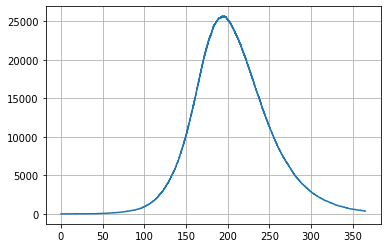

In [39]:
plt.plot(sims[0][0][:,0],sims[0][0][:,2],drawstyle='steps-post');
plt.grid()

In [46]:
!epidemiad/epidemiad

last R: 22.4392
197 ms, 754 μs, and 5 hnsecs
Number of steps: 245680, 245680,245680,245680


Como podemos ver, a versão em D é 6 vezes mais rápida que a versão Python.

In [48]:
dsim = pd.read_csv('epidemiad/sim.csv')
dsim.head()

,time,S,I,dt
0,0.00000,149998,2,0.00000
1,5.67831,149997,3,5.67831
2,8.86424,149996,4,3.18593
3,10.97380,149995,5,2.10953
4,11.15560,149995,4,0.18181


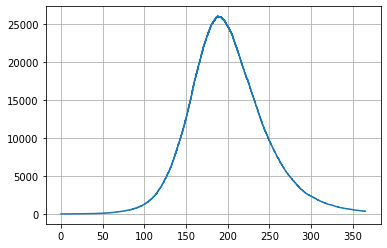

In [49]:
plt.plot(dsim.time,dsim[' I'],drawstyle='steps-post');
plt.grid();

Index(['time', ' S', ' I', ' dt'], dtype='object')